
# Notebook Hakkında
Bu defter, CNN tabanlı model kullanarak hazırlanan bir derin öğrenme projesidir. Projede veri setimizin görüntü sınıflandırmasını, veri analizini, model geliştirmeyi, sonuçlar üzerinde değerlendirme ve yorum yapmayı hedeflemektedir.

Veri kümesinde 75 farklı Kelebek sınıfı bulunur. Veri kümesi, doğrulama görüntüleri de dahil olmak üzere yaklaşık 1000'den fazla etiketli görüntü içerir. Her resim yalnızca bir kelebek kategorisine aittir.


# Kütüphanelerin İmport Edilmesi


In [1]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import cv2

import time
import warnings
warnings.filterwarnings('ignore')

# GPU kullanılabilirliği
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

2025-09-26 20:21:45.821198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758918106.091192      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758918106.160161      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


# Veri Seti

## Veri Setini Yükleme
butterfly-image-classification isimli veri setinin veri yapısına göre flow_from_dataframe() yöntemiyle veri setini yükleyeceğiz. 


In [2]:
# Dosya yolları
data_dir = "/kaggle/input/butterfly-image-classification"
train_img_dir = os.path.join(data_dir, "train")
csv_path = os.path.join(data_dir, "Training_set.csv")
test_csv_path = os.path.join(data_dir, "Testing_set.csv")

#Dosya okuma
df = pd.read_csv(csv_path)
test_df = pd.read_csv(test_csv_path)

## Veri Setini İnceleme

In [3]:
#ilk satır kontrol etme
df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [4]:
print(f"Toplam etiket sayısı: {df['label'].nunique()}")
print(f"Toplam eğitim verisi sayısı: {len(df)}")

Toplam etiket sayısı: 75
Toplam eğitim verisi sayısı: 6499


## Veri Setini Görselleştirme

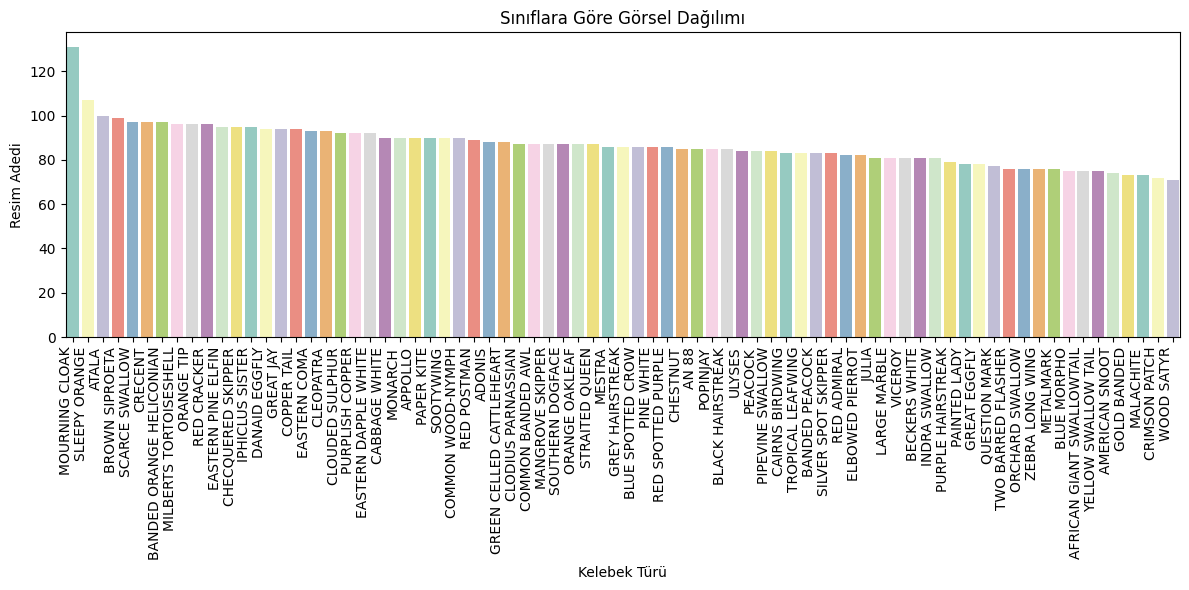

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index, palette="Set3")
plt.xticks(rotation=90, ha="right")
plt.title("Sınıflara Göre Görsel Dağılımı")
plt.xlabel("Kelebek Türü")
plt.ylabel("Resim Adedi")
plt.tight_layout()
plt.show()

Veri setinde bulunan görsellerin kelebek türlerine göre dağılımını tablolaştırdık ve analiz ettik.

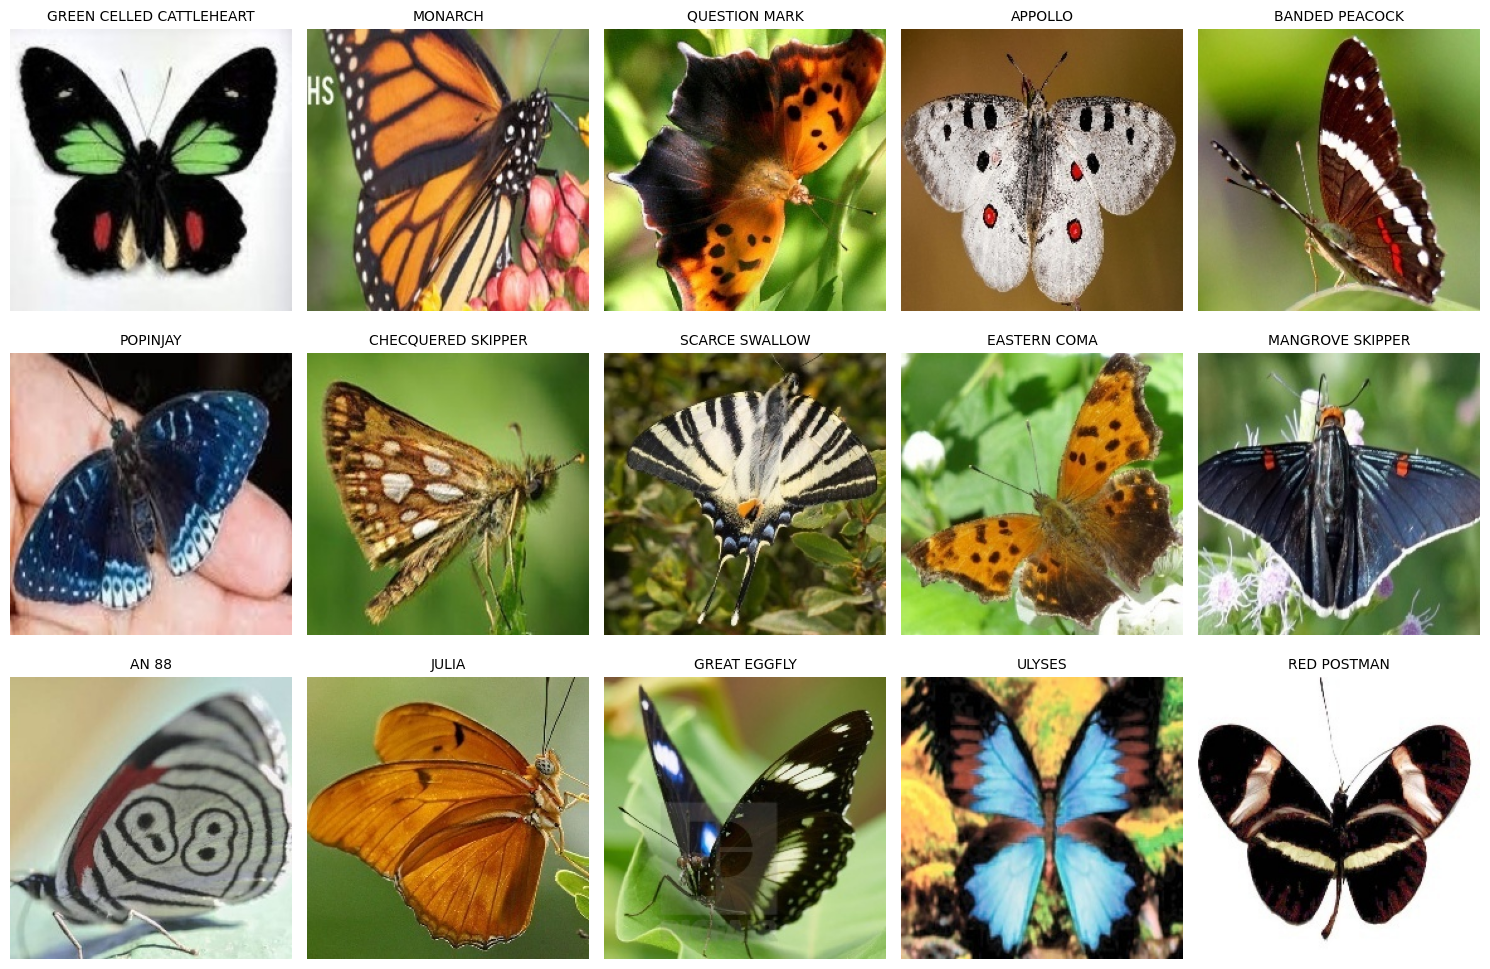

In [6]:
# 15 rastgele örnek seç
sample_df = df.sample(15, random_state=42).reset_index(drop=True)

# Plot ayarları
plt.figure(figsize=(15, 10))


for i in range(15):
    img_path = os.path.join(data_dir, "train", sample_df.loc[i, "filename"]) #görsellerin yolu doğru şekilde birleştirilir.
    label = sample_df.loc[i, "label"]
    
    # Görseli oku ve göster
    img = mpimg.imread(img_path)
    plt.subplot(3, 5, i + 1)  # 3 satır, 5 sütun grid oluşturur
    plt.imshow(img)
    plt.title(label, fontsize=10) #her görselin üstüne (ya da altına) etiketini yazar
    plt.axis("off")

plt.tight_layout()
plt.show()


Eğitim veri setimizi incelemek için içinden rastgele 15 veriyi seçip etiketleriyle beraber görselleştirdik.

## Veri Ön İşleme
Görüntüleri normalize ederek ve veri artırma teknikleri uygulayarak model performansını iyileştireceğiz.

In [7]:
# Görselleri [0, 1] aralığına normalize etme ve augmentasyon ekleme
datagen = ImageDataGenerator(
    rescale=1./255, # Görselleri [0, 255] aralığından [0, 1] aralığına getirir
    rotation_range=15, # Görselleri rastgele -15 ile +15 derece arasında döndürür (açıya duyarsızlık kazandırır)
    width_shift_range=0.1, # Görselleri yatayda %10 oranında rastgele kaydırır
    height_shift_range=0.1, # Görselleri dikeyde %10 oranında rastgele kaydırır
    zoom_range=0.1, # Görselleri rastgele %10 oranında yakınlaştırır veya uzaklaştırır
    horizontal_flip=True, # Görselleri yatayda rastgele çevirir (örneğin kelebek sağa bakıyorsa sola çevrilir)
    validation_split=0.2  # Eğitim verisinin %20'sini doğrulama (validation) verisi olarak ayırır
)

# Eğitim ve Doğrulama Generator’larını oluşturma
train_generator = datagen.flow_from_dataframe(
    
    dataframe=df,  
    # Etiket bilgilerini içeren pandas DataFrame.

    x_col='filename',  
    # Görsellerin dosya adlarını içeren sütun adı (örneğin 'img1.jpg').
    # Bu sütundaki isimler directory ile birleştirilerek tam yol oluşturulur.

    y_col='label',  
    # Etiketleri (sınıf adlarını) içeren sütun adı.
    # Keras bu sütunu kullanarak sınıf eşleşmesi ve one-hot encoding yapar.

    directory=os.path.join(data_dir, 'train'),  
    # 'filename' kolonundaki dosyaların bulunduğu dizin.

    target_size=(128, 128),  
    # Bütün görseller bu boyuta yeniden ölçeklendirilir (resize).
    # Modelin giriş katmanı ile uyumlu olması gerekir.

    batch_size=32,  
    # Her batch’te modele verilecek görsel sayısı.
    # GPU belleğine göre genellikle 32, 64, 128 gibi değerler kullanılır.

    class_mode='categorical',  
    # Etiket formatı:
    # 'categorical' → one-hot encoding yapılır (çok sınıflı sınıflandırma için)

    subset='training',  
    # validation_split kullanıldığında, bu çağrı sadece 'training' verilerini içerir.
    # Bu sayede aynı DataFrame’den validation set de oluşturabiliriz.

    shuffle=True  
    # Her epoch'ta veriler rastgele karıştırılır.
    # Modelin ezber yapmasını engeller, daha iyi genelleme sağlar.
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',
    y_col='label',
    directory=os.path.join(data_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test Generator Oluşturma
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(data_dir, 'test'),  # test görsellerinin bulunduğu klasör
    x_col='filename',
    y_col=None,                   # Etiket yok
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,              # Etiket olmamalı
    shuffle=False                 # Sıralama önemli (tahminle eşleşmesi için)
)

X_batch, y_batch = next(train_generator)
X_test = next(test_generator)

print("Normalize edilmiş giriş verisi şekli:", X_batch.shape)
print("One-hot encoded etiket şekli:", y_batch.shape)
print("Test batch şekli:", X_test.shape)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.
Normalize edilmiş giriş verisi şekli: (32, 128, 128, 3)
One-hot encoded etiket şekli: (32, 75)
Test batch şekli: (32, 128, 128, 3)


# CNN Modelini Oluşturma

Verilerin ön işlemesi tamamlandı. Şimdi modelimizi oluşturabiliriz. İlk olarak, Keras'ın Sıralı API'sini kullanarak bir model nesnesi oluşturuyoruz.

In [8]:
model = models.Sequential([
    # 1. Evrişim Bloğu
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # 2. Evrişim Bloğu
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # 3. Evrişim Bloğu
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2d_last"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Sınıflandırıcı
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),   
    layers.Dropout(0.5),
    layers.Dense(75, activation='softmax')  # Sınıf sayısına göre çıkış
])

I0000 00:00:1758918147.493259      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758918147.494122      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


**Birinci Evrişim Bloğu**

Conv2D (32 filtre): Görselden kenar, doku, renk geçişi gibi temel özellikleri çıkarır.

MaxPooling2D: Özellik haritasını 2x2 havuzlama ile küçültür → boyut azalır, önemli özellikler kalır.

Dropout (0.25): %25 oranında nöronları devre dışı bırakarak overfitting’i azaltır.

**İkinci Evrişim Bloğu**

Daha derin seviyede şekil ve desen gibi orta düzey özellikleri öğrenir.

Filtre sayısı arttı → daha fazla özellik yakalanabilir.

Aynı şekilde boyutlar tekrar havuzlanarak küçültülür.

**Üçüncü Evrişim Bloğu**

Yüksek seviye özellikler: sınıfı ayırt edecek karmaşık yapılar öğrenilir.

128 filtre ile daha zengin bilgi çıkarımı yapılır.

**Sınıflandırma**

Flatten: 3D çıktı düzleştirilir → Fully Connected katmana verilebilir.

Dense(128): Öğrenilen özellikleri bir araya getirerek karar verir.

Dropout(0.5): %50 dropout ile aşırı öğrenmeyi azaltır.

Dense(num_classes): Sınıf sayısı kadar nöron, softmax aktivasyonu ile olasılık verir.

## Optimizer

Artık modelimizin yapısı hazır. Modeli eğitim için yapılandırmak üzere .compile() metodunu kullanacağız. Derleme metodunun içinde aşağıdakileri tanımlamamız gerekiyor:

In [9]:
# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Optimizer** için ağırlıkları güncelleyen algoritma 'Adam' tercih edildi. Öğrenme hızını otomatik ayarlayan güçlü ve yaygın bir optimizör.

**Loss Fonksiyonu** için 'Categorical Crossentropy' tercih edildi. Çok sınıflı sınıflandırma problemlerinde kullanılır (etiketler one-hot ise)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_last (Conv2D)            │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,492,523 (17.14 MB)

 Trainable params: 4,491,819 (17.13 MB)

 Non-trainable params: 704 (2.75 KB)

## Callbackleri Oluşturma

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. En iyi modeli kaydet
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',               # Kayıt yeri
    monitor='val_loss',                     # Takip edilecek metrik
    save_best_only=True,                    # En iyi olanı kaydet
    mode='min',                             # val_loss minimum olmalı
    verbose=1
)

# 2. Gelişme durursa eğitimi durdur
early_stop = EarlyStopping(
    monitor='val_loss',                     # Takip edilecek metrik
    patience=5,                             # 5 epoch boyunca gelişme yoksa durur
    restore_best_weights=True,              # En iyi ağırlıkları geri yükler
    verbose=1
)

# 3. Plateau durumunda öğrenme oranını düşür
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                             # Öğrenme oranını yarıya indir
    patience=3,                             # 3 epoch gelişme yoksa uygula
    min_lr=1e-6,                            # Minimum öğrenme oranı
    verbose=1
)

# Callback'leri bir listeye ekleyelim
callbacks = [checkpoint, early_stop, reduce_lr]

## Modeli Eğitme

Modeli eğitme zamanı. İlk iki argüman olarak X_train ve y_train veri kümelerini vereceğiz. Bunlar eğitim için kullanılacak. validation_data parametresiyle ise X_val ve y_val'i bir tuple olarak vereceğiz.

In [12]:
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=50,                            # Maksimum epoch sayısı
    validation_data=val_generator,
    callbacks=callbacks,                  # Daha önce tanımladığımız callback'ler
    verbose=1
)
training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

Epoch 1/50


I0000 00:00:1758918157.272719      64 service.cc:148] XLA service 0x7cf1280176e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758918157.273964      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758918157.273990      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758918158.010831      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.0234 - loss: 5.5169 

I0000 00:00:1758918167.642800      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.0595 - loss: 4.3142
Epoch 1: val_loss improved from inf to 4.93092, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 450ms/step - accuracy: 0.0597 - loss: 4.3115 - val_accuracy: 0.0115 - val_loss: 4.9309 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2144 - loss: 3.1140
Epoch 2: val_loss improved from 4.93092 to 4.20625, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - accuracy: 0.2145 - loss: 3.1133 - val_accuracy: 0.0293 - val_loss: 4.2062 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3226 - loss: 2.6273
Epoch 3: val_loss improved from 4.20625 to 2.74176, saving model to best_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.3226 - loss: 2.6271 - val_accuracy: 0.2995 - val_loss: 2.7418 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3712 

### Eğitim Başarımı Görselleştirme

Model eğitildikten sonra, zaman içindeki kayıp değişimini görselleştirmek için bir grafik oluşturabiliriz. Sonuçlar şurada tutulur:
* history.history["loss"]
* history.history["val_loss"]


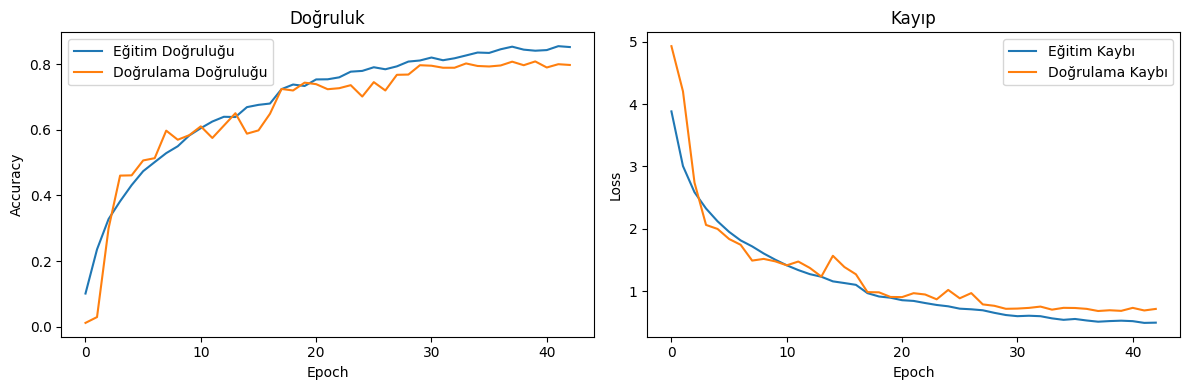

In [13]:
# Eğitim ve doğrulama doğruluğu
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Modeli Değerlendirme

Oluşturduğumuz validasyon veri setini kullanarak modelin performansını değerlendireceğiz.

In [14]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Kaybı: {val_loss:.4f}")
print(f"Validation Doğruluğu: {val_accuracy:.4f}")



Validation Kaybı: 0.6930
Validation Doğruluğu: 0.8114


### Tahminde Bulunma

Daha sonra, başlangıçta seçtiğimiz örneği alıp bunun üzerine bir tahminde bulunuyoruz.


In [15]:
# Tahminler
val_preds = model.predict(val_generator)
val_pred_classes = np.argmax(val_preds, axis=1)

# Gerçek etiketler
val_true_classes = val_generator.classes

# Sınıf isimleri
class_names = list(val_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step


## Sınıflandırma Raporu

In [16]:
print("\nSınıflandırma Raporu:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_names))



Sınıflandırma Raporu:
                           precision    recall  f1-score   support

                   ADONIS       0.89      0.89      0.89        19
AFRICAN GIANT SWALLOWTAIL       1.00      0.88      0.94        17
           AMERICAN SNOOT       0.86      0.75      0.80        16
                    AN 88       0.94      0.94      0.94        17
                  APPOLLO       0.86      0.86      0.86        14
                    ATALA       1.00      0.78      0.88        23
 BANDED ORANGE HELICONIAN       0.83      0.79      0.81        19
           BANDED PEACOCK       0.92      0.69      0.79        16
            BECKERS WHITE       0.78      0.88      0.82        16
         BLACK HAIRSTREAK       1.00      0.85      0.92        27
              BLUE MORPHO       0.67      0.60      0.63        10
        BLUE SPOTTED CROW       0.93      0.88      0.90        16
           BROWN SIPROETA       0.92      0.85      0.88        26
            CABBAGE WHITE       0.83  

## Karmaşıklık Matrisi

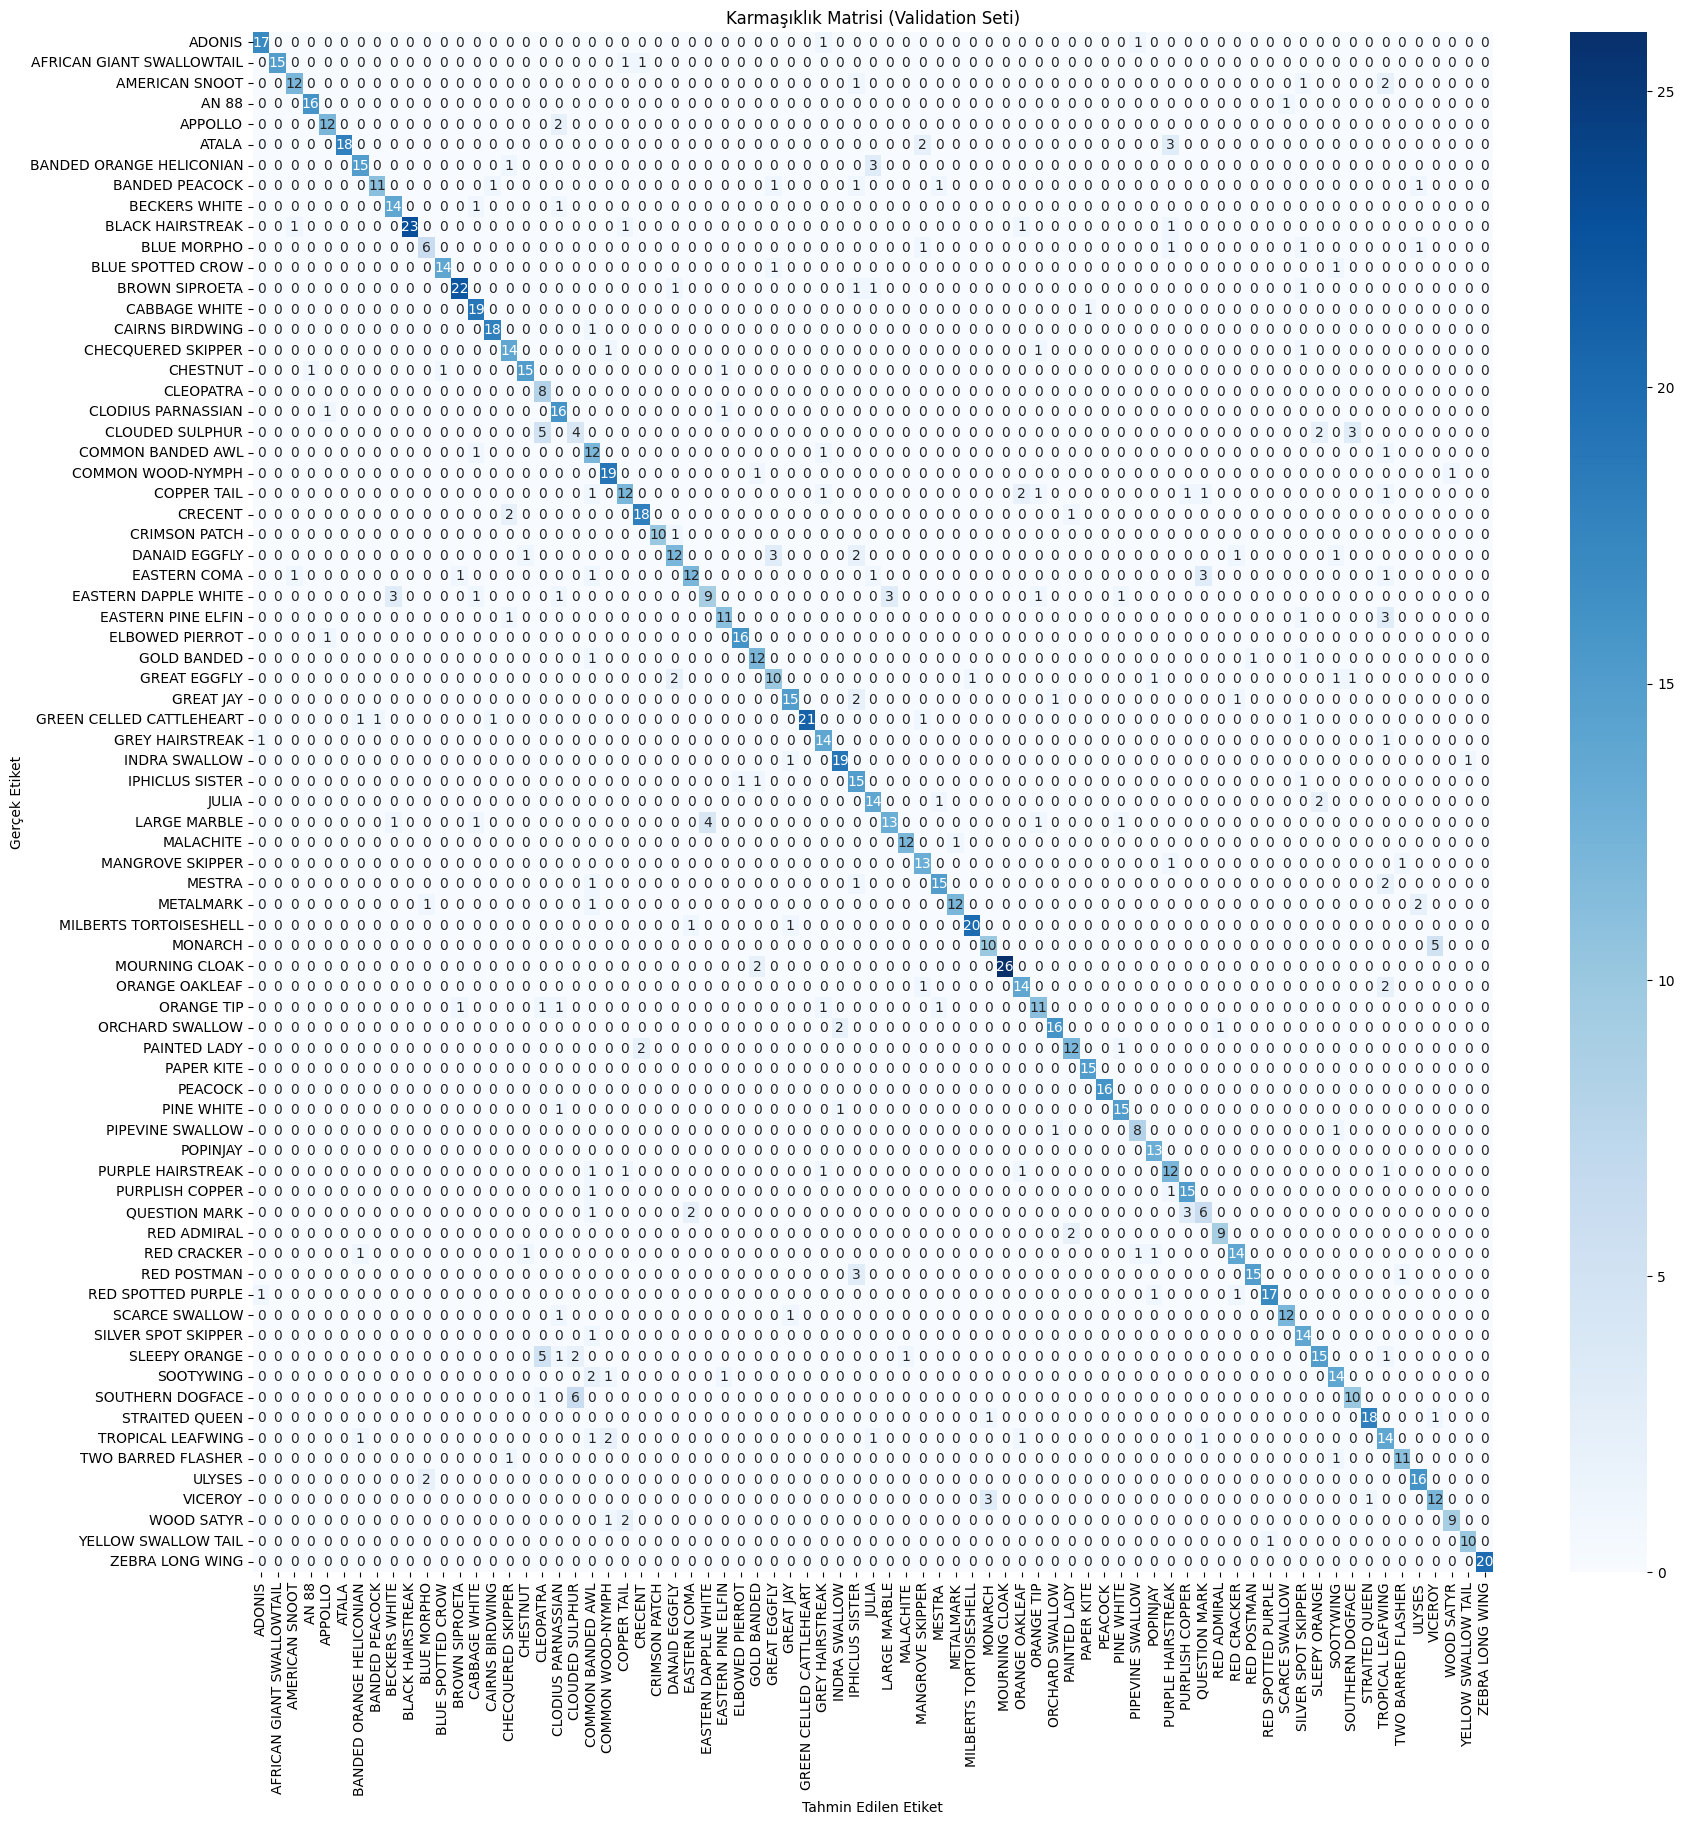

In [17]:

cm = confusion_matrix(val_true_classes, val_pred_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Karmaşıklık Matrisi (Validation Seti)')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

## Tahmin Görselleştirme

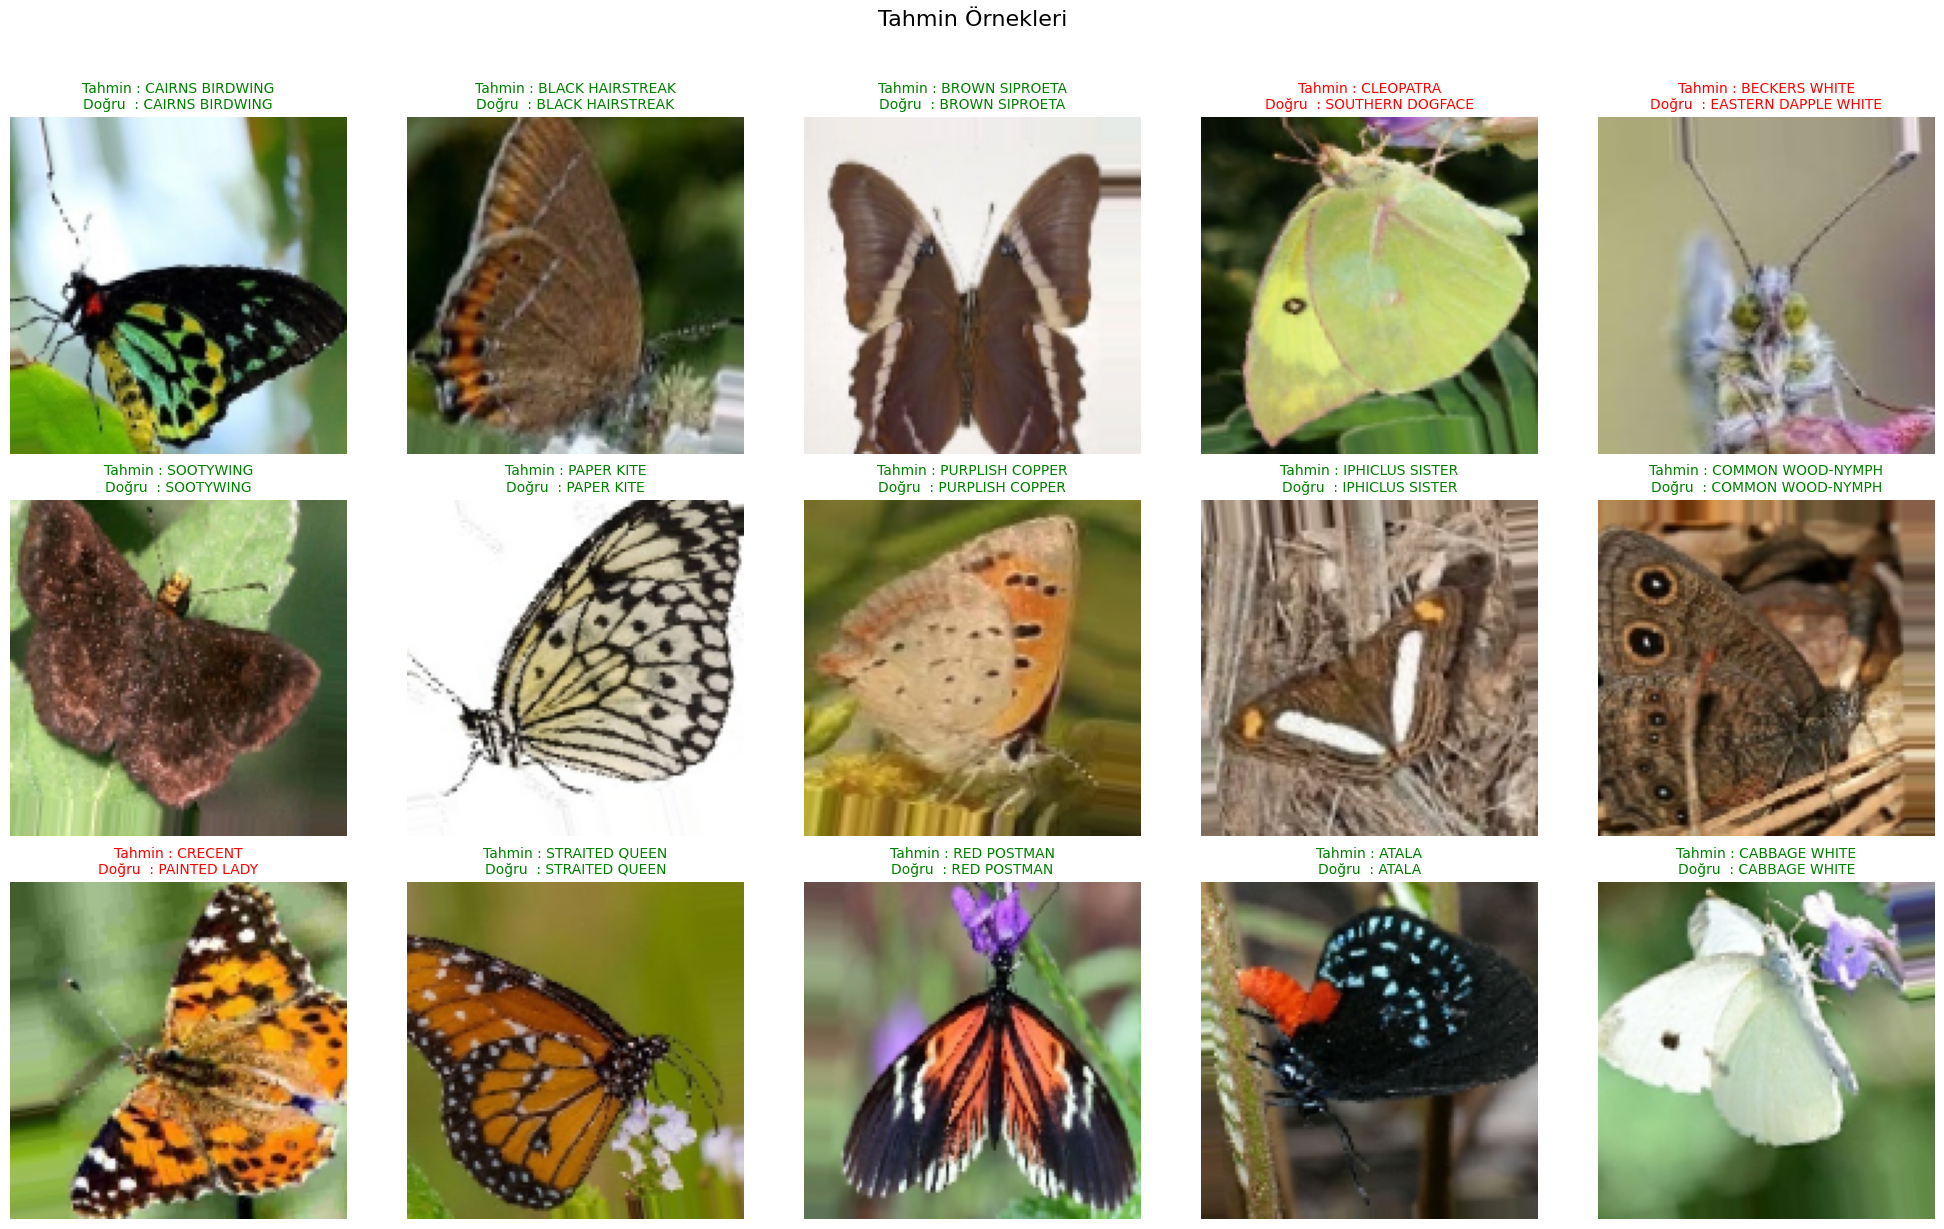

In [18]:
val_images, val_labels = next(val_generator)

random_indices = np.random.choice(len(val_images), size=15, replace=False)

plt.figure(figsize=(20, 12))

for i, idx in enumerate(random_indices):
    pred_label = class_names[val_pred_classes[idx]]
    true_label = class_names[val_true_classes[idx]]
    
    plt.subplot(3, 5, i + 1)
    plt.imshow(val_images[idx])
    plt.axis('off')
    
    title_text = f"Tahmin : {pred_label}\nDoğru  : {true_label}"
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(title_text, fontsize=10, color=title_color)

plt.suptitle("Tahmin Örnekleri", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Heatmap Görselleştirme (Grad-CAM)

In [19]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Modeli bir kez çalıştırarak graph oluştur
    _ = model(img_array)

    # Grad-CAM için yeni model tanımla
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient hesapla
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    # Kanal başına ortalama grad
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Feature map + grad çarpımı
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize et
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 1. Modeli build et
dummy_input = tf.zeros((1, 128, 128, 3))
_ = model(dummy_input)

# 2. Grad-CAM fonksiyonunu çağır
heatmap = make_gradcam_heatmap(
    sample_array, 
    model, 
    last_conv_layer_name="conv2d_last"
)

# 3. Heatmap göster
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()


NameError: name 'sample_array' is not defined

# Hiperparametre Optimizasyonu

In [ ]:
import keras_tuner as kt

# Modeli inşa eden fonksiyon
def build_model(hp):
    model = models.Sequential()
    
    # 1. Conv Block
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(128, 128, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    
    # 2. Conv Block
    model.add(layers.Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv4_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout2', 0.3, 0.6, step=0.1)))
    
    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout3', 0.3, 0.6, step=0.1)))
    
    # Output
    model.add(layers.Dense(75, activation='softmax'))
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Tuner oluştur (RandomSearch yerine Hyperband de kullanabilirsin)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,                 # kaç kombinasyon denenecek
    executions_per_trial=1,        # her deneme 1 kez çalıştırılsın
    directory='tuner_results',
    project_name='butterfly_cnn'
)

# Taramayı başlat
tuner.search(train_generator, epochs=15, validation_data=val_generator)

# En iyi modelleri al
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]

# En iyi hiperparametreleri yazdır
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Seçilen En İyi Hiperparametreler:")
print("conv1_filters:", best_hps.get('conv1_filters'))
print("conv2_filters:", best_hps.get('conv2_filters'))
print("conv3_filters:", best_hps.get('conv3_filters'))
print("conv4_filters:", best_hps.get('conv4_filters'))
print("dense_units:", best_hps.get('dense_units'))
print("dropout1:", best_hps.get('dropout1'))
print("dropout2:", best_hps.get('dropout2'))
print("dropout3:", best_hps.get('dropout3'))
print("learning_rate:", best_hps.get('learning_rate'))


## Modeli Tekrar Eğitme

In [ ]:
# En iyi hiperparametrelerle yeni model oluştur
model_opt = build_model(best_hps)

history_opt = model_opt.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks, 
    verbose=1
)


In [ ]:
val_opt_loss, val_opt_accuracy = model_opt.evaluate(val_generator, verbose=1)
print(f"Optimize Model Validation Kaybı: {val_opt_loss:.4f}")
print(f"Optimize Model Validation Doğruluğu: {val_opt_accuracy:.4f}")

## Optimasyon Sonrası Karşılaştırma

In [ ]:
plt.figure(figsize=(12,5))

# Doğruluk
plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='Eski Model')
plt.plot(history_opt.history['val_accuracy'], label='Optimize Model')
plt.title('Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp
plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Eski Model')
plt.plot(history_opt.history['val_loss'], label='Optimize Model')
plt.title('Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Sonuçlar

In [ ]:
print(f"Temel Model Doğruluğu: {val_accuracy:.4f}")
print(f"Optimize Model Validation Kaybı: {val_opt_accuracy:.4f}")